In [1]:
import os
import json
from PIL import Image
from collections import Counter

import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from skimage import draw

import pytorch_lightning as pl
import torch
import torchvision
from torchvision import transforms as T
import segmentation_models_pytorch as smp


from torch.utils.data import Dataset, DataLoader, Subset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from scipy.ndimage import label

In [2]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    GaussNoise, MotionBlur, MedianBlur, PiecewiseAffine,
    Sharpen, Emboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, Normalize, Resize, RandomBrightnessContrast
)
from albumentations.pytorch import ToTensorV2

# TODO: add stain aug
def get_transforms(mode='val'):
    
    if mode == 'train':
        return Compose([
            Resize(512, 512),
            GaussNoise(p=0.3),
            OneOf([
                MotionBlur(p=0.2),
                MedianBlur(blur_limit=3, p=0.1),
                Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            OneOf([
                OpticalDistortion(p=0.3),
                GridDistortion(p=0.1),
                PiecewiseAffine(p=0.3),
            ], p=0.2),
            OneOf([
                Sharpen(),
                Emboss(),
                RandomBrightnessContrast(),
            ], p=0.3),
            HueSaturationValue(p=0.3),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    return Compose([
        Resize(512, 512),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [3]:
BASE_FILENAME = '../data/'
BATCH_SIZE = 16
NUM_WORKERS = 5
# BASE_FILENAME = '/kaggle/input/hubmap-hacking-the-human-vasculature'

In [4]:
class HubmapDataset(Dataset):

    def __init__(self, image_dir, df, transforms):
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, f"{row.id}.tif")
        image = np.array(Image.open(image_path))
        mask = np.zeros((512, 512), dtype=np.float32)
        for coords in row.annotation:
            for cord in coords:
                rr, cc = np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord])
                rr, cc = draw.polygon(rr, cc)
                mask[rr, cc] = 1

        sample = self.transforms(image=image, mask=mask)
        sample['wsi'] = row.source_wsi
        sample['ds'] = row.dataset
        return sample

In [5]:
train_transforms = get_transforms(mode='train')
val_transforms = get_transforms(mode='val')

In [6]:
def make_annotation(folder):
    meta = pd.read_csv(f'{folder}/tile_meta.csv')
    rows = []
    with open(f'{folder}/polygons.jsonl', 'r') as json_file:
        for line in json_file:
            data = json.loads(line)
            row = dict({'id': data['id']})
            coords = []
            for ann in data['annotations']:
                if ann['type'] == 'blood_vessel':
                    coords.append(ann['coordinates'])
            row['annotation'] = coords
            rows.append(row)
    df = pd.DataFrame(rows)
    df = df.merge(meta, on='id')
    return df

In [7]:
df = make_annotation(BASE_FILENAME)

In [8]:
df

,id,annotation,source_wsi,dataset,i,j
0,0006ff2aa7cd,"[[[[283, 109], [282, 109], [281, 109], [280, 1...",2,2,16896,16420
1,00168d1b7522,"[[[[501, 257], [500, 257], [499, 257], [498, 2...",2,2,14848,14884
2,0033bbc76b6b,"[[[[169, 228], [168, 228], [167, 228], [166, 2...",1,1,10240,43008
3,003504460b3a,"[[[[40, 401], [39, 401], [38, 401], [37, 401],...",3,2,8192,11776
4,004daf1cbe75,"[[[[147, 234], [146, 234], [145, 234], [144, 2...",3,2,6144,11264
...,...,...,...,...,...,...
1628,ff434af74304,"[[[[294, 477], [293, 477], [292, 477], [291, 4...",4,2,3072,22528
1629,ff4897b3eda6,"[[[[299, 509], [298, 509], [297, 509], [296, 5...",4,2,11776,20992
1630,ff66dec71c4c,"[[[[119, 306], [118, 306], [117, 306], [116, 3...",3,2,5120,10752
1631,ff99cdef0f2a,"[[[[245, 131], [244, 131], [243, 131], [242, 1...",4,2,5120,24064


In [9]:
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

In [10]:
train_dataset = HubmapDataset(f'{BASE_FILENAME}/train', train_df, train_transforms)
val_dataset = HubmapDataset(f'{BASE_FILENAME}/train', val_df, val_transforms)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=5)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=5)

In [12]:
import cv2
def plot_sample(image, mask):

    image = image.permute(1, 2, 0).numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225]) 
    image = (image * std) + mean


    masked = image.copy()
#     masked[mask == 1] = [1, 0, 0]  # Red color for mask
    mask = mask.numpy().astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_mask = cv2.drawContours(masked, contours, -1, (1), thickness=3)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[1].imshow(contours_mask)
    ax[1].set_title('Image with mask')

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

    plt.show()


In [13]:
i = np.random.choice(range(len(train_dataset)))

In [14]:
image, mask, _, _ = train_dataset[i].values()

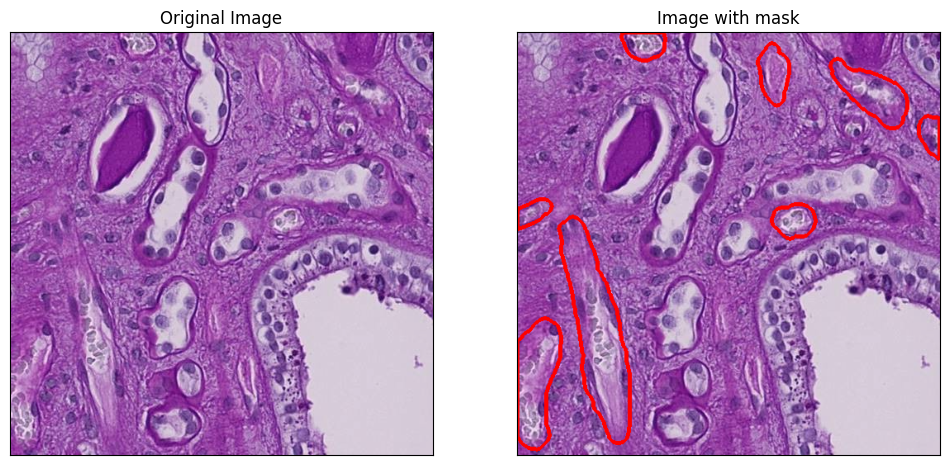

In [15]:
plot_sample(image, mask)

In [19]:
class LitModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=3, classes=1, **kwargs
        )

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, batch):
        # normalize image here
        image = batch["image"]
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        mask = batch["mask"].unsqueeze(1)
        logits_mask = self.forward(batch)
        loss = self.loss_fn(logits_mask, mask)


        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        self.log(f"loss/{stage}", loss)
        self.log(f"iou/{stage}", per_image_iou)

        
        return {
            "loss": loss,
            "iou": per_image_iou,
        }
    
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=1e-3)

In [20]:
arch = 'UnetPlusPlus' 
encoder_name = 'efficientnet-b7'    

In [21]:
name = f'{arch}+{encoder_name}'

In [22]:
# smp.encoders.get_encoder_names()

In [23]:
model = LitModel(arch, encoder_name)

In [24]:
from pytorch_lightning_sam_callback import SAM

In [25]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices=[0],
    max_epochs=100,
    logger=pl.loggers.TensorBoardLogger("../tb_logs_segm", name=name),
    log_every_n_steps=10,
    callbacks=[SAM()],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
# !pip install pytorch-lightning-sam-callback

In [27]:
trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name    | Type         | Params
-----------------------------------------
0 | model   | UnetPlusPlus | 68.2 M
1 | loss_fn | DiceLoss     | 0     
-----------------------------------------
68.2 M    Trainable params
0         Non-trainable params
68.2 M    Total params
272.654   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/home/worker/miniconda3/envs/hubmap/lib/python3.9/multiprocessing/queues.py", line 244, in _feed
    obj = _ForkingPickler.dumps(obj)
  File "/home/worker/miniconda3/envs/hubmap/lib/python3.9/multiprocessing/reduction.py", line 51, in dumps
    cls(buf, protocol).dump(obj)
  File "/home/worker/.local/lib/python3.9/site-packages/torch/multiprocessing/reductions.py", line 329, in reduce_storage
    df = multiprocessing.reduction.DupFd(fd)
  File "/home/worker/miniconda3/envs/hubmap/lib/python3.9/multiprocessing/reduction.py", line 198, in DupFd
    return resource_sharer.DupFd(fd)
  File "/home/worker/miniconda3/envs/hubmap/lib/python3.9/multiprocessing/resource_sharer.py", line 48, in __init__
    new_fd = os.dup(fd)
OSError: [Errno 9] Bad file descriptor


Training: 0it [00:00, ?it/s]

Exception ignored in: <function _releaseLock at 0x7fe98fc34ca0>
Traceback (most recent call last):
  File "/home/worker/miniconda3/envs/hubmap/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
  File "/home/worker/.local/lib/python3.9/site-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 1268213) is killed by signal: Aborted. 
2023-07-25 19:43:22.085502: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [30]:
i = 1
os.makedirs(f"../checkpoints/{arch}/{encoder_name}/")
torch.save(trainer.model.model.state_dict(), f"../checkpoints/{arch}/{encoder_name}/{i}.pth")